In [38]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
import json

from src.vae_models import VAE, VAEFraudTrainer, compute_reconstruction_errors
from src.evaluation import FraudEvaluationMetrics

import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4070 SUPER


## 1. Configuration Setup

In [39]:
model_path = '../../models/vae_baseline.pth'

if os.path.exists(model_path):
    print("Loading pre-trained VAE baseline model...")
    
    # Load checkpoint (PyTorch 2.6+ requires weights_only=False for custom objects)
    checkpoint = torch.load(model_path, weights_only=False, map_location='cpu')
    
    # Extract results from checkpoint
    results = checkpoint['metrics']
    config = checkpoint['config']
    
    print("\n" + "="*60)
    print("PRE-TRAINED MODEL LOADED SUCCESSFULLY")
    print("="*60)
    print(f"\nModel Configuration:")
    print(f"  Input Dim: {config['input_dim']}")
    print(f"  Hidden Dim: {config['hidden_dim']}")
    print(f"  Latent Dim: {config['latent_dim']}")
    print(f"  Beta: {config['beta']}")
    
    print(f"\nTest Set Performance:")
    print(f"  Total Cost: ${int(results['test_cost']):,}")
    print(f"  Precision: {results['test_precision']:.3f}")
    print(f"  Recall: {results['test_recall']:.3f}")
    if 'test_pr_auc' in results:
        print(f"  PR-AUC: {results['test_pr_auc']:.4f}")
    
    print(f"\nOptimal Threshold: {checkpoint['optimal_threshold']:.6f}")
    print(f"Training Time: {checkpoint.get('timestamp', 'N/A')}")
    
    print("\n✓ You can now skip to Section 3 (Model Comparison)")
else:
    print(f"Model not found at {model_path}")
    print("Please run the training cell below to train a new model.")

Loading pre-trained VAE baseline model...

PRE-TRAINED MODEL LOADED SUCCESSFULLY

Model Configuration:
  Input Dim: 22
  Hidden Dim: 128
  Latent Dim: 16
  Beta: 1.0

Test Set Performance:
  Total Cost: $20,790
  Precision: 0.984
  Recall: 0.252

Optimal Threshold: 5.090549
Training Time: 2025-10-12 20:12:53

✓ You can now skip to Section 3 (Model Comparison)


In [40]:
# Training configuration
config = {
    # Data
    'data_path': '../../data/processed/creditcard_fe.csv',
    'drop_features': 'logreg_baseline',  # Use same features as logistic regression
    
    # Model architecture
    'hidden_dim': 128,
    'latent_dim': 16,
    'beta': 1.0,
    
    # Training
    'learning_rate': 1e-3,
    'epochs': 50,
    'batch_size': 256,
    
    # Business costs 
    'C_FP': 550,  # False positive cost (investigation)
    'C_FN': 110,  # False negative cost (missed fraud)
    
    # Hardware
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'random_seed': 42,
    
    # Save paths
    'model_save_path': '../../models/vae_baseline.pth',
    'results_save_path': '../../results/figures/vae_baseline_training.png'
}

print("Baseline VAE Configuration:")
print("=" * 50)
for key, value in config.items():
    print(f"{key:20s}: {value}")

Baseline VAE Configuration:
data_path           : ../../data/processed/creditcard_fe.csv
drop_features       : logreg_baseline
hidden_dim          : 128
latent_dim          : 16
beta                : 1.0
learning_rate       : 0.001
epochs              : 50
batch_size          : 256
C_FP                : 550
C_FN                : 110
device              : cuda
random_seed         : 42
model_save_path     : ../../models/vae_baseline.pth
results_save_path   : ../../results/figures/vae_baseline_training.png


## 2. Train VAE Baseline Model

In [41]:
# Train the VAE baseline model using the trainer
trainer = VAEFraudTrainer(config)
test_results = trainer.run()

VAE FRAUD DETECTION TRAINING

[1/6] Loading and preparing data...
Loading data from ../../data/processed/creditcard_fe.csv...
Dataset loaded: 284807 transactions
  Normal: 284315 (99.83%)
  Fraud: 492 (0.17%)
  Features: 22
  Dropped features: 14

Data split:
  Training: 170589 normal transactions
  Validation: 57109 transactions (246 fraud)
  Test: 57109 transactions (246 fraud)

[2/6] Scaling features...
Features scaled using StandardScaler

[3/6] Training VAE on CUDA...
Epoch 10/50 - Train Loss: 11.9785, Val Loss: 11.9472
Epoch 20/50 - Train Loss: 11.6249, Val Loss: 11.5728
Epoch 30/50 - Train Loss: 11.4599, Val Loss: 11.4423
Epoch 40/50 - Train Loss: 11.3599, Val Loss: 11.3503
Epoch 50/50 - Train Loss: 11.3124, Val Loss: 11.2914

Training completed!
  Final training loss: 11.3124
  Final validation loss: 11.2914

[4/6] Finding optimal business threshold...
Testing threshold values from 50th to 99.9th percentile...
Optimal threshold found: 5.090549
Minimum validation cost: $22,000



In [47]:
checkpoint = torch.load('../../models/vae_baseline.pth', weights_only=False, map_location='cpu')

evaluator = FraudEvaluationMetrics(cost_fp=550, cost_fn=110)

vae_metrics = checkpoint['metrics']

print("VAE Baseline Model Loaded")
print("=" * 60)
print(f"Total Cost: ${int(vae_metrics['test_cost']):,}")
print(f"Precision: {vae_metrics['test_precision']:.4f}")
print(f"Recall: {vae_metrics['test_recall']:.4f}")
print(f"PR-AUC: {vae_metrics.get('pr_auc', 0):.4f}")
print(f"False Positives: {vae_metrics['fp']}")
print(f"False Negatives: {vae_metrics['fn']}")

VAE Baseline Model Loaded
Total Cost: $20,790
Precision: 0.9841
Recall: 0.2520
PR-AUC: 0.6000
False Positives: 1
False Negatives: 184


In [48]:
# Load logistic regression baseline results
with open('../../results/baseline/logreg_results.json', 'r') as f:
    logreg_results = json.load(f)

print("\nLogistic Regression Baseline Results")
print("=" * 60)
print(f"Total Cost: ${logreg_results['total_cost']:,}")
print(f"False Positives: {logreg_results['false_positives']}")
print(f"False Negatives: {logreg_results['false_negatives']}")
print(f"True Positives: {logreg_results['true_positives']}")
print(f"True Negatives: {logreg_results['true_negatives']}")

# Calculate precision and recall for logistic regression
logreg_precision = logreg_results['true_positives'] / (logreg_results['true_positives'] + logreg_results['false_positives'])
logreg_recall = logreg_results['true_positives'] / (logreg_results['true_positives'] + logreg_results['false_negatives'])

print(f"Precision: {logreg_precision:.4f}")
print(f"Recall: {logreg_recall:.4f}")


Logistic Regression Baseline Results
Total Cost: $43,450
False Positives: 41
False Negatives: 190
True Positives: 302
True Negatives: 284274
Precision: 0.8805
Recall: 0.6138


In [49]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'VAE Baseline'],
    'Precision': [
        logreg_precision,
        vae_metrics['test_precision']
    ],
    'Recall': [
        logreg_recall,
        vae_metrics['test_recall']
    ],
    'Total Cost': [
        logreg_results['total_cost'],
        int(vae_metrics['test_cost'])
    ],
    'FP': [
        logreg_results['false_positives'],
        vae_metrics['fp']
    ],
    'FN': [
        logreg_results['false_negatives'],
        vae_metrics['fn']
    ]
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

# Calculate cost savings
cost_diff = logreg_results['total_cost'] - int(vae_metrics['test_cost'])
cost_reduction_pct = (cost_diff / logreg_results['total_cost']) * 100

print(f"\n{'='*60}")
print(f"Cost Comparison:")
print(f"  LogReg Cost: ${logreg_results['total_cost']:,}")
print(f"  VAE Cost: ${int(vae_metrics['test_cost']):,}")
print(f"  Savings: ${cost_diff:,} ({cost_reduction_pct:.1f}%)")

if cost_diff > 0:
    print(f"  ✓ VAE is ${cost_diff:,} cheaper than Logistic Regression")
else:
    print(f"  ✗ VAE is ${abs(cost_diff):,} more expensive than Logistic Regression")


MODEL COMPARISON
              Model  Precision   Recall  Total Cost  FP  FN
Logistic Regression   0.880466 0.613821       43450  41 190
       VAE Baseline   0.984127 0.252033       20790   1 184

Cost Comparison:
  LogReg Cost: $43,450
  VAE Cost: $20,790
  Savings: $22,660 (52.2%)
  ✓ VAE is $22,660 cheaper than Logistic Regression


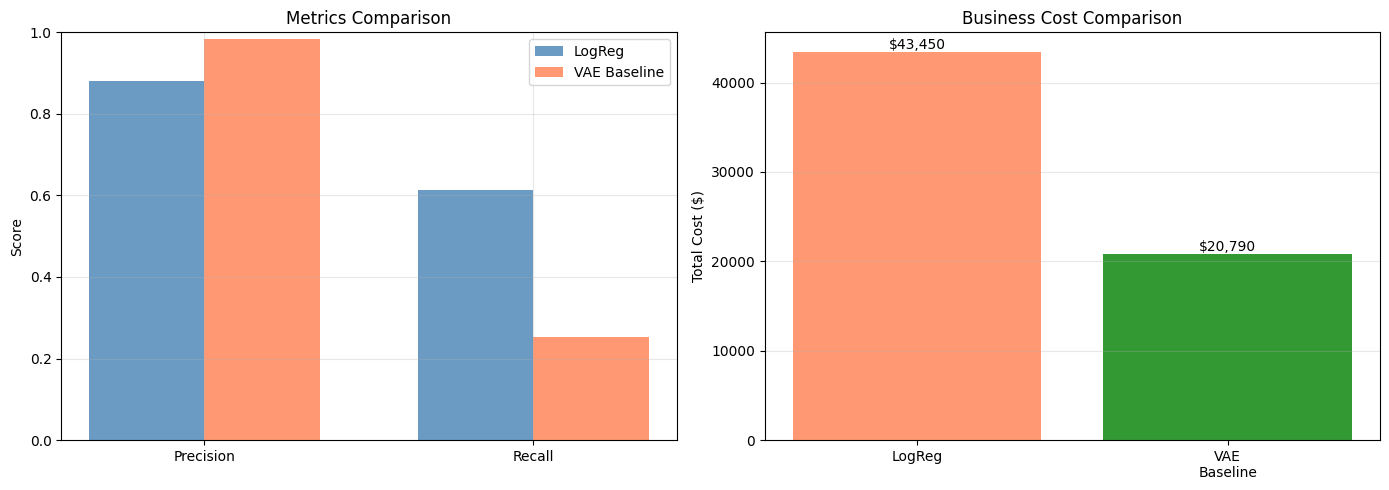


Visualization saved to: results/figures/vae_baseline_vs_logreg.png


In [50]:
# Comparison Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Metrics comparison
metrics_names = ['Precision', 'Recall']
logreg_vals = [logreg_precision, logreg_recall]
vae_vals = [vae_metrics['test_precision'], vae_metrics['test_recall']]

x = np.arange(len(metrics_names))
width = 0.35

axes[0].bar(x - width/2, logreg_vals, width, label='LogReg', alpha=0.8, color='steelblue')
axes[0].bar(x + width/2, vae_vals, width, label='VAE Baseline', alpha=0.8, color='coral')
axes[0].set_ylabel('Score')
axes[0].set_title('Metrics Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.0])

# Plot 2: Cost comparison
models = ['LogReg', 'VAE\nBaseline']
costs = [logreg_results['total_cost'], int(vae_metrics['test_cost'])]
colors = ['green' if c == min(costs) else 'coral' for c in costs]

axes[1].bar(models, costs, alpha=0.8, color=colors)
axes[1].set_ylabel('Total Cost ($)')
axes[1].set_title('Business Cost Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

for i, (model, cost) in enumerate(zip(models, costs)):
    axes[1].text(i, cost, f'${cost:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../../results/figures/vae_baseline_vs_logreg.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: results/figures/vae_baseline_vs_logreg.png")

In [51]:
# Save comparison results
comparison_results = {
    'logistic_regression': {
        'precision': float(logreg_precision),
        'recall': float(logreg_recall),
        'total_cost': logreg_results['total_cost'],
        'fp': logreg_results['false_positives'],
        'fn': logreg_results['false_negatives'],
        'tp': logreg_results['true_positives'],
        'tn': logreg_results['true_negatives']
    },
    'vae_baseline': {
        'precision': float(vae_metrics['test_precision']),
        'recall': float(vae_metrics['test_recall']),
        'pr_auc': float(vae_metrics.get('pr_auc', 0)),
        'total_cost': int(vae_metrics['test_cost']),
        'fp': int(vae_metrics['fp']),
        'fn': int(vae_metrics['fn']),
        'tp': int(vae_metrics['tp']),
        'tn': int(vae_metrics['tn'])
    },
    'cost_savings': {
        'absolute': cost_diff,
        'percentage': cost_reduction_pct
    }
}

# Save to JSON
with open('../../results/vae_baseline_comparison.json', 'w') as f:
    json.dump(comparison_results, f, indent=2)

# Also save CSV
comparison_df.to_csv('../../results/vae_baseline_comparison.csv', index=False)

print("\nResults saved:")
print("  - results/vae_baseline_comparison.json")
print("  - results/vae_baseline_comparison.csv")


Results saved:
  - results/vae_baseline_comparison.json
  - results/vae_baseline_comparison.csv
